In [1]:
!ls ../data/ # check data availability

car_test.csv    driver_info.csv outputs
car_train.csv   fix_info.csv    rides_info.csv


In [2]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #, mean_squared_error

### Analyzing cars data

The main description of cars with information about breakdowns for train/test (`car_train.csv`/`car_test.csv`)
**Columns Description:**  
- `car_id` - id of the car  
- `model / car_type / fuel_type` - car model, class and fuel type of cars  
- `car_racing / riders` - overall rating and total number of trips by the end of 2021   
- `year_to_start / year_to_work` - the year of the car's release and the start of work in the fleet  
- `main_city` - the city where the car is located. (Moscow or St. Petersburg)  
- `target_reg` - the number of days before the breakdown.  
- `target_class` - breakdown class (9 types in total)  

(2337, 10)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
319,G-1064210J,Smart Coupe,economy,petrol,5.60,2017,129539,2020,36.73,gear_stick
806,v-1935966T,Hyundai Solaris,economy,petrol,4.70,2012,22882,2017,43.95,engine_overheat
1496,U10311712e,VW Polo,economy,petrol,6.08,2011,2409,2018,29.46,engine_overheat
411,P13663597M,Kia Sportage,standart,petrol,4.16,2015,77634,2016,57.08,engine_ignition
1519,B13169162p,Smart ForFour,economy,petrol,3.86,2014,64041,2018,32.54,engine_fuel


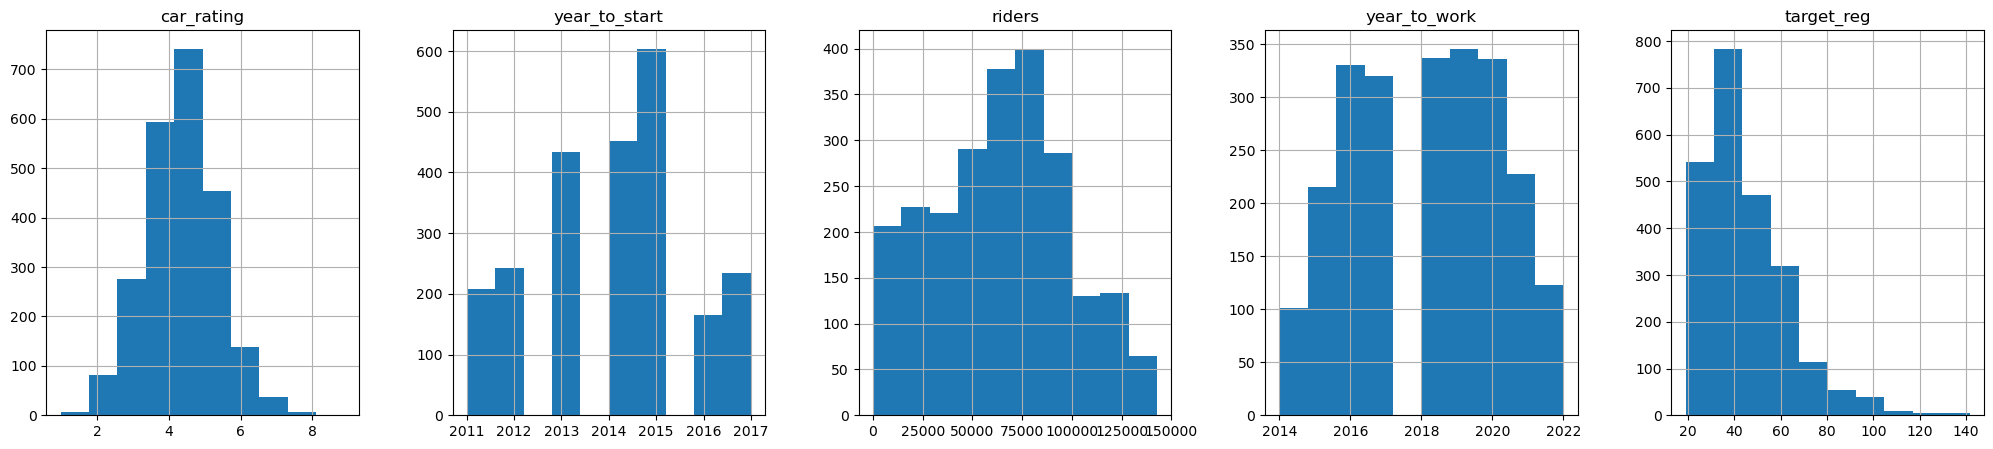

In [3]:
path = '../data/car_train.csv'
train = pd.read_csv(path)
print(train.shape)
train.hist(figsize=(25, 5), layout = (-1, 5))
train.sample(5)

In [4]:
path = '../data/car_test.csv'
test = pd.read_csv(path)
print(test.shape)
test.sample(5)

(1913, 8)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work
253,A41423630m,VW Tiguan,economy,petrol,4.56,2013,36218,2020
56,T65731704H,Smart Coupe,economy,petrol,3.90,2017,125978,2017
1163,J-2100035F,Smart Coupe,economy,petrol,4.00,2015,87477,2018
847,t11482362Y,Smart ForFour,economy,petrol,3.20,2017,113298,2021
858,L-1777501Y,Smart ForTwo,economy,petrol,4.66,2015,80713,2019


### Dividing features into groups based on their types

In [5]:
features2drop = ['car_id'] 
targets = ['target_class', 'target_reg']  
cat_features = ['car_type', 'fuel_type', 'model'] 

filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]


print('cat_features :', len(cat_features), cat_features)
print('num_features :', len(num_features), num_features)
print('targets', targets)

cat_features : 3 ['car_type', 'fuel_type', 'model']
num_features : 4 ['car_rating', 'year_to_start', 'riders', 'year_to_work']
targets ['target_class', 'target_reg']


### Train with Catboost and score test data

In [6]:
X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = CatBoostClassifier(cat_features=cat_features, n_estimators = 100)


clf.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=150, plot=False)

# model results
y_pred = clf.predict(X_test)
print(f'\n Accuracy: {accuracy_score(y_test, y_pred)}')

Learning rate set to 0.263488
0:	learn: 2.1785390	test: 2.1943955	best: 2.1943955 (0)	total: 69.5ms	remaining: 6.88s
99:	learn: 1.4720249	test: 2.3118861	best: 2.1851470 (5)	total: 1.55s	remaining: 0us

bestTest = 2.185146963
bestIteration = 5

Shrink model to first 6 iterations.

 Accuracy: 0.11324786324786325


In [7]:
test['target_class'] = [x[0] for x in clf.predict(test[filtered_features])]
test[['car_id', 'target_class']].to_csv('../data/outputs/simple_baseline_v1.csv', index=False)
print('CSV file saved!')

CSV file saved!


### Add rides information - `rides_info.csv`.  

**Columns Description:**
- `user_id` / `car_id` / `ride_id` - id's of the driver, car, ride, respectively
- `ride_date` / `rating` - the date of the ride and the rating given by the driver
- `ride_duration` / `distance` / `ride_cost` -  ride duration (time),  distance traveled, ride cost
- `speed_avg` / `speed_max` - average and maximum speed of the ride, respectively
- `stop_times` / `refueling` - the number of stops (pauses) and the flag - whether there was refueling
- `user_ride_quality` - assessment of the driving manner in the driver's car, determined by the Machine Learning system of the service, which gives it a score.
- `deviation_normal` - the general indicator of the sensors about the condition of the car, relative to the reference indicators (norms).


In [8]:
path = '../data/rides_info.csv'
rides = pd.read_csv(path)
rides.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
557079,b13580442h,n-5767544o,K1v,2020-02-25,1.31,57,849,42,65.0,1,1745.520195,0,2.863114,12.469
130687,f20159953W,J-1675931Y,F1S,2020-01-08,4.80,62,552,39,46.0,2,1988.761361,0,3.921432,0.000
319593,o54375261x,W17936165j,U1Y,2020-03-09,5.81,54,534,49,61.0,2,2519.226271,0,-2.891167,0.596
481633,t17163338t,i-1260000J,i1Z,2020-01-01,5.15,56,890,36,64.0,1,1624.531564,0,-1.660583,19.587
425782,q86330937c,e-1713473l,e1v,2020-01-03,3.60,5,40,61,66.0,0,260.600607,0,-0.540255,-34.762


In [9]:
f = lambda x: x.nunique()
rides_df_gr = rides.groupby('car_id', as_index=False).agg(mean_rating = ('rating', 'mean'),
                                                   distance_sum = ('distance', 'sum'),
                                                   rating_min = ('rating', 'min'),
                                                   speed_max = ('speed_max', 'max'),
                                                   user_ride_quality_median = ('user_ride_quality', 'median'), 
                                                   deviation_normal_count = ('deviation_normal', 'count'),
                                                   user_uniq = ('user_id', f))


rides_df_gr.head(2)

,car_id,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,A-1049127W,4.255172,1.125753e+07,0.1,179.729652,-0.288229,174,172
1,A-1079539w,4.088046,1.912765e+07,0.1,184.505566,2.508746,174,173


In [10]:
def add_featues(df):
    
    if 'mean_rating' not in df.columns:
        return df.merge(rides_df_gr, on = 'car_id', how = 'left')
    
    return df
    
    
train = add_featues(train)
test = add_featues(test)
train.sample(2)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
480,r-2150771s,Hyundai Solaris,economy,petrol,4.36,2011,4907,2014,25.60,engine_fuel,4.329138,6.314289e+06,0.1,161.763226,-13.225721,174,172
108,r-1098555x,VW Polo,economy,petrol,5.28,2015,76719,2020,27.25,engine_fuel,4.152874,1.550423e+07,0.1,159.721874,15.725594,174,172


In [11]:
train.to_csv('../data/outputs/quickstart_train.csv', index=False)

### Update features' types once again

In [12]:
filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]


print('num_features :', len(num_features), num_features)
print('cat_features :', len(cat_features), cat_features)
print('targets', targets)

num_features : 11 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq']
cat_features : 3 ['car_type', 'fuel_type', 'model']
targets ['target_class', 'target_reg']


### Train Catboost on new dataset (with new features added: rides info aggregated values)

In [13]:
X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = CatBoostClassifier(cat_features=cat_features, n_estimators = 150)


clf.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=150, plot=False)

# инференс модели
y_pred = clf.predict(X_test)
print(f'\n Accuracy: {accuracy_score(y_test, y_pred)}')

Learning rate set to 0.22568
0:	learn: 1.6212387	test: 1.6497106	best: 1.6497106 (0)	total: 30.8ms	remaining: 4.58s
149:	learn: 0.2063057	test: 0.5608913	best: 0.5499245 (65)	total: 2.83s	remaining: 0us

bestTest = 0.5499244647
bestIteration = 65

Shrink model to first 66 iterations.

 Accuracy: 0.7948717948717948


In [14]:
fi = clf.get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,speed_max,37.047152
1,mean_rating,32.232507
2,rating_min,15.861294
3,user_uniq,3.280420
4,car_type,3.191561
5,user_ride_quality_median,1.989592
6,car_rating,1.735900
7,riders,1.708250
8,distance_sum,1.489515
9,year_to_work,1.170172


In [15]:
test['target_class'] = [x[0] for x in clf.predict(test[filtered_features])]
test[['car_id', 'target_class']].to_csv('../data/outputs/simple_baseline_v2.csv', index=False)
print('CSV file saved!')

CSV file saved!
